In [1]:
import os
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [2]:
urls = search_images('samoyed', max_images=1)
urls[0]

Searching for 'samoyed'


'https://www.petpaw.com.au/wp-content/uploads/2014/06/Samoyed-4.jpg'

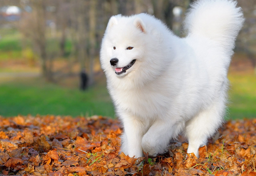

In [3]:
from fastdownload import download_url
dest = 'samoyed.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'how person looks in webcam'


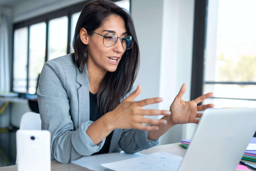

In [4]:
download_url(search_images('how person looks in webcam', max_images=1)[0], 'webcam.jpg', show_progress=False)
Image.open('webcam.jpg').to_thumb(256,256)

In [5]:
searches = 'how person looks in webcam','samoyed'
path = Path('samoyed_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'how person looks in webcam photo'
Searching for 'samoyed photo'


In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

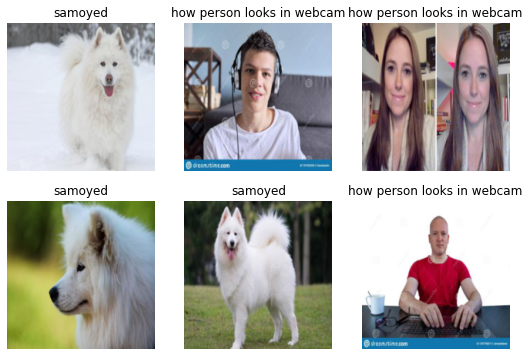

In [7]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [8]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(8)

C:\Users\rando\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\rando\AppData\Roaming\Python\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.872793,0.455767,0.200000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.981153,0.157809,0.000000,00:01
1,0.800626,0.018758,0.000000,00:01
2,0.552170,0.001526,0.000000,00:01
3,0.411968,0.000246,0.000000,00:01
4,0.326535,0.000073,0.000000,00:01
5,0.269449,0.000035,0.000000,00:01
6,0.228603,0.000027,0.000000,00:01
7,0.198167,0.000031,0.000000,00:01


In [ ]:
import cv2
from PIL import Image
from fastai.vision.all import *
from fastai.data.external import *
import time

cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error opening camera")
    exit()
font = cv2.FONT_HERSHEY_SIMPLEX

while True:
    #time.sleep(0.1)
    ret, frame = cap.read()
    if not ret:
        print("Error reading frame")
        break
    

    
    # Convert the color channels from BGR to RGB
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)    
    img =  Image.fromarray(img)
    img = img.resize((256,256))

    samoyed, _, probs = learn.predict(img)
    
    cv2.putText(frame, f'{samoyed} {probs}', (10,450), font, 3, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.imshow("Webcam", frame)

    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()